In [23]:
import tensorflow as tf

Step 1: Import Keras & packages

In [24]:
from tensorflow.python.keras.layers import Input, Dense, Activation, Dropout, MaxPooling1D, Flatten, LSTM, Convolution1D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.utils.data_utils import get_file
from timeit import default_timer as timer 
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as scs
import random
import sys
import os
import glob

In [25]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"#set the gpu to use, use nvidia-smi to check id

Step 2: Import data, set input parameters and plot the distribution for visualisation

In [51]:
alldata = []
filenames = ['./Sec_III_B/LPF2.dat']#Please specify the filename to be trained and tested
weightname ='IIIb_LPF2' #Specify the name to call this set of data

# Length of input. Treating each input that consists of 100 "words" as a "sentence".
maxlen = 100 #Default is 100
# Distance between 2 consecutive "sentences"
step = 15 #Default is 3, can be increased to speed up the training. The smaller the step, the higher the accurancy

#Batch the data, default is len(test1_list)=100000. 
#Change this to smaller value if there is memory issue, or for validation. 
#Alternatively, the user can increase this (up to 1000000) if user's hardware permits. 
#If an error occurs due to memory, will need to re-run Step 2 due to clear memory steps in step 5
new_size = 100000 


Data:IIIb_LPF2
Mean= -20.8908714
Standard Deviation= 30.071270128623787
Max-probability 0.0136928


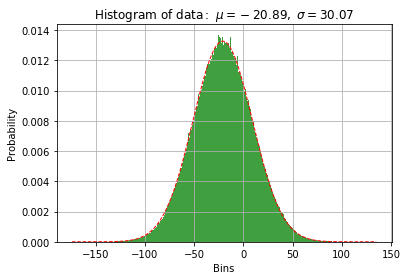

(10000000,)


In [52]:
print('Data:'+weightname)

for filename in filenames:
    data = np.fromfile(filename, dtype='>i2') #datatype is big-endian 2byte signed integer, as compared to '<u4'
    data = data[2:]   # exclude first two header values 
    data = data >> 3  # shift right by 3 bits  
    alldata.append(data)
    
data=data[:5000000]    
mu, sigma = np.mean(data), np.std(data)
#print('Mean='(mu),'Standard Deviation=' len(sigma))
print('Mean=',mu)
print('Standard Deviation=',sigma)

# the histogram of the data
n, bins, patches = plt.hist(data, list(range(np.min(data),np.max(data)+2)), density=1, facecolor='green', alpha=0.75)
print('Max-probability',max(n))

# add a 'best fit' line
y = scs.norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Bins')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of \ data:}\ \mu=%.2f,\ \sigma=%.2f$' % (mu,sigma))
plt.grid(True)

plt.show()

del data  #delete data

alldata = np.concatenate(alldata)    
print(alldata.shape)

In [53]:
text = alldata[:5000000]#Training set
#Test sets
test1 = alldata[5000000:6000000]
test2 = alldata[6000000:7000000]
test3 = alldata[7000000:8000000]
test4 = alldata[8000000:9000000]
test5 = alldata[9000000:]

text = list(text)
test1 = list(test1)
test2 = list(test2)
test3 = list(test3)
test4 = list(test4)
test5 = list(test5)
text = map(str,text)
test1 = map(str,test1)
test2 = map(str,test2)
test3 = map(str,test3)
test4 = map(str,test4)
test5 = map(str,test5)
text_list = list(text)
test1_list = list(test1)
test2_list = list(test2)
test3_list = list(test3)
test4_list = list(test4)
test5_list = list(test5)

del text
del test1
del test2
del test3
del test4
del test5

print(len(text_list), len(test1_list), len(test5_list))

5000000 1000000 1000000


Step 3: Preparing the data for ML

In [29]:
# Treating each number as a "word". Creating a dictionary.
alldata = alldata.astype(np.str)
chars = sorted(list(set(alldata)))

print(chars)
del alldata
print('Total words:', len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

['-1', '-10', '-100', '-101', '-102', '-103', '-104', '-105', '-106', '-107', '-108', '-109', '-11', '-110', '-111', '-112', '-113', '-114', '-115', '-116', '-117', '-118', '-119', '-12', '-120', '-121', '-122', '-123', '-124', '-125', '-126', '-127', '-128', '-129', '-13', '-130', '-131', '-132', '-133', '-134', '-135', '-136', '-137', '-138', '-139', '-14', '-140', '-141', '-142', '-143', '-144', '-145', '-146', '-147', '-148', '-149', '-15', '-150', '-151', '-152', '-153', '-154', '-155', '-156', '-157', '-158', '-159', '-16', '-160', '-161', '-162', '-163', '-164', '-166', '-169', '-17', '-174', '-18', '-19', '-2', '-20', '-21', '-22', '-23', '-24', '-25', '-26', '-27', '-28', '-29', '-3', '-30', '-31', '-32', '-33', '-34', '-35', '-36', '-37', '-38', '-39', '-4', '-40', '-41', '-42', '-43', '-44', '-45', '-46', '-47', '-48', '-49', '-5', '-50', '-51', '-52', '-53', '-54', '-55', '-56', '-57', '-58', '-59', '-6', '-60', '-61', '-62', '-63', '-64', '-65', '-66', '-67', '-68', '-69',

In [30]:
sentences = []
next_chars = []
for i in range(0, len(text_list) - maxlen, step):
    sentences.append(text_list[i: (i + maxlen)])
    next_chars.append(text_list[(i + maxlen)])
print('nb sequences:', len(sentences))


print('Start vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):        
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('Done vectorization!')

nb sequences: 99998
Start vectorization...
Done vectorization!


Step 4: Build model and train the data

In [31]:
# build the RCNN model
print('Build model...')
model = Sequential()
model.add(Convolution1D(filters=64, kernel_size=9, padding='same', activation='relu', input_shape=(maxlen, len(chars))))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=0.0005), metrics=['accuracy'])
print(model.summary())
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
weight ='weights_'+weightname+'.hdf5'
print(weight)
monitoring = ModelCheckpoint(weight, monitor='val_loss', verbose=1, save_best_only=True)

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 64)           171136    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 297) 

In [8]:
#Epoch set to 50, can be changed to smaller value for code validation
model.fit(X, y, epochs=50, batch_size=128, validation_split=0.2, verbose=1, callbacks=[early_stopping,monitoring])
# Loads the weights
model.load_weights(weight)

Train on 1333307 samples, validate on 333327 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
1333248/1333307 [============================>.] - ETA: 0s - loss: 4.8300 - acc: 0.0134
Epoch 00001: val_loss improved from inf to 4.82817, saving model to weights_Q3b_ch1_gpu.hdf5
1333307/1333307 [==============================] - 3357s 3ms/sample - loss: 4.8300 - acc: 0.0134 - val_loss: 4.8282 - val_acc: 0.0137
Epoch 2/50
1333248/1333307 [============================>.] - ETA: 0s - loss: 4.8250 - acc: 0.0137
Epoch 00002: val_loss did not improve from 4.82817
1333307/1333307 [==============================] - 3297s 2ms/sample - loss: 4.8250 - acc: 0.0137 - val_loss: 4.8284 - val_acc: 0.0133
Epoch 3/50
1333248/1333307 [============================>.] - ETA: 0s - loss: 4.8239 - acc: 0.0138
Epoch 00003: val_loss improved from 4.82817 to 4.82779, saving model to weights_Q3b_ch1_gpu.hdf5
1333307/1333307 [==============================

Step 5: Perform the test for ML

In [ ]:
#Perform the tests over 5 sets of data
tests = [test1_list,test2_list,test3_list,test4_list,test5_list]

#clear memory
del test1_list
del test2_list
del test3_list
del test4_list
del test5_list

#start the testing
start = timer()
average = 0
for test in tests:
    n_batch = int(len(test)/new_size)
    for ib in range(n_batch):
        test_ = test[ib*new_size:(ib+1)*new_size]
    
        maxlen = 100
        step = 1
        sentences = []
        next_chars = []
        for i in range(0, len(test_) - maxlen, step):
            sentences.append(test_[i: (i + maxlen)])
            next_chars.append(test_[(i + maxlen)])
        print('nb sequences:', len(sentences))

        print('Vectorization...')
        Xt = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
        yt = np.zeros((len(sentences), len(chars)), dtype=np.bool)
        for i, sentence in enumerate(sentences):

            for t, char in enumerate(sentence):        
                Xt[i, t, char_indices[char]] = 1       
            yt[i, char_indices[next_chars[i]]] = 1
        n_true = 0
        diversity = 1
        for i,x in enumerate(Xt):
            if i % 100000 == 0:
                print ("Processed %d %d" % (i,n_true))
            x = x.reshape(1,maxlen,-1)
            preds = model.predict(x, verbose=0)[0]
            next_index = np.argmax(preds)      
            next_char = indices_char[next_index]
            if next_char == indices_char[np.argmax(yt[i])]:
                n_true += 1
        print ("%d_%d_%.5f" % (n_true,yt.shape[0],(float(n_true)/yt.shape[0])))
        average = average + (float(n_true)/yt.shape[0])
print("Time taken: %.5f hours, P_ML = %.5f" % (float(timer()-start)/3600, average/(5*n_batch)))